In [1]:
# Installing xgboost  
! pip install pyspellchecker
! pip install xgboost==0.80


In [2]:
# Importing Libraries 
import pandas as pd
import numpy as np
import re
import nltk
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report,roc_curve
from sklearn.metrics.pairwise import pairwise_distances

In [3]:
#Downliading stopwords
nltk.download('punkt')
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sr069609\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sr069609\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Downloading wordnet for lemmitization
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sr069609\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Sentiment Analysis

#### Data Cleaning and EDA

In [5]:
#Loading the data set
df=pd.read_csv('sample30.csv')

In [6]:
#Printing the shape(rows and columns) of the dataset
df.shape

(30000, 15)

In [7]:
#Printing top 5 entries in the dataset
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


##### As we can see we have many columns in the dataframe which are not required for text analysis, so, we will only keep the required columns in the data frame which are reviews_text, reviews_title and user_sentiment and name

In [8]:
#Creating new dataframe with mentioned above data
sentiment_df = df[['name','reviews_text','reviews_title','user_sentiment']]

In [9]:
#Checking the shape of the new dataframe
sentiment_df.shape

(30000, 4)

In [10]:
#Printing first few entries in dataframe
sentiment_df.head()

,name,reviews_text,reviews_title,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Just Awesome,Positive
1,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Good,Positive
2,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,Good,Positive
3,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Disappointed,Negative
4,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Irritation,Negative


In [11]:
#Checking the datframe entries
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            30000 non-null  object
 1   reviews_text    30000 non-null  object
 2   reviews_title   29810 non-null  object
 3   user_sentiment  29999 non-null  object
dtypes: object(4)
memory usage: 937.6+ KB


In [12]:
sentiment_df.describe()

,name,reviews_text,reviews_title,user_sentiment
count,30000,30000,29810,29999
unique,271,27282,18535,2
top,Clorox Disinfecting Wipes Value Pack Scented 1...,Great,Great Product,Positive
freq,8545,16,384,26632


In [13]:
#checking number of columns with null values 
sentiment_df.isnull().sum()*100/sentiment_df.shape[0]

name              0.000000
reviews_text      0.000000
reviews_title     0.633333
user_sentiment    0.003333
dtype: float64

In [14]:
# Checking positive and negative distribution in user sentiments column
sentiment_df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

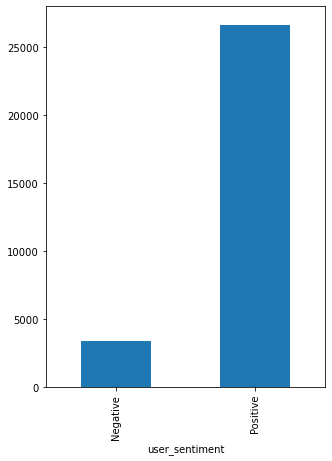

In [15]:
#Plotting graph for negative vs positive
plt.figure(figsize=(5,7))
ax = sentiment_df.groupby('user_sentiment').user_sentiment.count().plot.bar()
plt.show()

#### Analysis: As we can see data is highly imbalanced

In [16]:
sentiment_df['reviews_title'].value_counts()

Great Product                            384
Great movie                              361
Clorox Wipes                             278
Great                                    221
Great product                            205
                                        ... 
A great moisturizer that really works      1
Always like to have windex around          1
Amazing conditioner!                       1
Like it better than Prego                  1
Great zilla movie!                         1
Name: reviews_title, Length: 18535, dtype: int64

##### Missing value treatment

In [17]:
#We will replace NA/null values in user_sentiment column with mode of the column
sentiment_df['user_sentiment']=sentiment_df['user_sentiment'].fillna(sentiment_df['user_sentiment'].mode()[0])

In [18]:
#We will replace na/null values in review_text column with 'is'
sentiment_df['reviews_title']=sentiment_df['reviews_title'].fillna('is')

In [19]:
#Validating if all the null values are gone or not
round(100*(sentiment_df.isnull().sum()/len(sentiment_df.index)), 2)

name              0.0
reviews_text      0.0
reviews_title     0.0
user_sentiment    0.0
dtype: float64

In [20]:
#Merging review text and review_title into new column
sentiment_df['review_tt']= sentiment_df['reviews_text'] + ' '+sentiment_df['reviews_title']

In [21]:
#Checking review_tt column and printing one of the entry
sentiment_df['review_tt'][5]

'My boyfriend and I bought this to spice things up in the bedroom and we were both highly disappointed in this product. We bought this one because we absolutely love the ky yours and mine and we thought this would have a similar affect but it did absolutely nothing. Do not buy. Not worth it'

In [22]:
#Creating target variable
sentimentTarget_df=sentiment_df.pop('user_sentiment')

In [23]:
#Checking the shape of the new dataframe
sentimentTarget_df.shape

(30000,)

In [24]:
#Checking the dataframe after the above changes
sentiment_df.head(5)

,name,reviews_text,reviews_title,review_tt
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Just Awesome,i love this album. it's very good. more to the...
1,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Good,Good flavor. This review was collected as part...
2,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor.,Good,Good flavor. Good
3,K-Y Love Sensuality Pleasure Gel,I read through the reviews on here before look...,Disappointed,I read through the reviews on here before look...
4,K-Y Love Sensuality Pleasure Gel,My husband bought this gel for us. The gel cau...,Irritation,My husband bought this gel for us. The gel cau...


In [25]:
#Checking the shape of the dataframe after the above changes
sentiment_df.shape

(30000, 4)

In [26]:
#Dropping the review_text and review_title column as we already have that information in new column review_tt
sentiment_df.drop(['reviews_text','reviews_title'],inplace=True,axis=1)

In [27]:
#Checking the shape of the dataframe after removing the 2 columns
sentiment_df.shape

(30000, 2)

#### Text Processing 

In [28]:
#Converting all the data to lower case
sentiment_df['name']=sentiment_df['name'].apply(lambda x:x.lower())
sentiment_df['review_tt']=sentiment_df['review_tt'].apply(lambda x:x.lower())

In [29]:
#Checking the dataframe after the case conversion
sentiment_df.head(5)

,name,review_tt
0,pink friday: roman reloaded re-up (w/dvd),i love this album. it's very good. more to the...
1,lundberg organic cinnamon toast rice cakes,good flavor. this review was collected as part...
2,lundberg organic cinnamon toast rice cakes,good flavor. good
3,k-y love sensuality pleasure gel,i read through the reviews on here before look...
4,k-y love sensuality pleasure gel,my husband bought this gel for us. the gel cau...


In [30]:
#Checking for random lines which have other characters except a-z alphabets and space character
print(sentiment_df['review_tt'][10])

tried it with my husband and felt no different there was no effect no change first te using ky gel not sure if i want to try any others... pretty dissapoitned


In [31]:
#Removing all the character from the text data except the alphabets and space character
sentiment_df['review_tt']=sentiment_df['review_tt'].apply(lambda txt:re.sub("[^a-zA-Z ]*","",txt))


In [32]:
#Checking the same data after removing characters which are not necessary
print(sentiment_df['review_tt'][10])

tried it with my husband and felt no different there was no effect no change first te using ky gel not sure if i want to try any others pretty dissapoitned


#### We can see the ... were there previously which is now removed

In [33]:
#Removing space from the sentence and storing it in a new variable
NoSpace_Str = sentiment_df['review_tt'].str.len() ==0
sentiment_df.loc[NoSpace_Str].index

Int64Index([], dtype='int64')

In [34]:
#Checking the data frame
sentiment_df.head()

,name,review_tt
0,pink friday: roman reloaded re-up (w/dvd),i love this album its very good more to the hi...
1,lundberg organic cinnamon toast rice cakes,good flavor this review was collected as part ...
2,lundberg organic cinnamon toast rice cakes,good flavor good
3,k-y love sensuality pleasure gel,i read through the reviews on here before look...
4,k-y love sensuality pleasure gel,my husband bought this gel for us the gel caus...


In [35]:
#Creating Tokens
sentiment_df['review_tt']=sentiment_df['review_tt'].apply(lambda txt:word_tokenize(txt))

In [36]:
#Checking the Tokens
sentiment_df['review_tt'][1]

['good',
 'flavor',
 'this',
 'review',
 'was',
 'collected',
 'as',
 'part',
 'of',
 'a',
 'promotion',
 'good']

In [37]:
#Checking the data frame after tokenization
sentiment_df.head()

,name,review_tt
0,pink friday: roman reloaded re-up (w/dvd),"[i, love, this, album, its, very, good, more, ..."
1,lundberg organic cinnamon toast rice cakes,"[good, flavor, this, review, was, collected, a..."
2,lundberg organic cinnamon toast rice cakes,"[good, flavor, good]"
3,k-y love sensuality pleasure gel,"[i, read, through, the, reviews, on, here, bef..."
4,k-y love sensuality pleasure gel,"[my, husband, bought, this, gel, for, us, the,..."


In [38]:
#Removing the stopwords
sentiment_df['review_tt']=sentiment_df['review_tt'].apply(lambda word:[item for item in word if item not in stopwords.words('english')])

In [39]:
#Checking for data after removal of stop words
sentiment_df['review_tt'][1]

['good', 'flavor', 'review', 'collected', 'part', 'promotion', 'good']

In [40]:
#Removing 'ion', 'er' from the suffix of a word (Stemming of words)
porter_stemmer = PorterStemmer()
sentiment_df['review_tt']=sentiment_df['review_tt'].apply(lambda p:[porter_stemmer.stem(item) for item in p])

In [41]:
#dataframe after the removal of prefix
sentiment_df['review_tt'][1]

['good', 'flavor', 'review', 'collect', 'part', 'promot', 'good']

##### Now that we have removed all the prefixes and stopwords, the purpose of tokenization has been solved. We can join the words back and make it as a sentence again

In [42]:
#Adding a new column where the data is not tokenized in the dataframe
sentiment_df['review_tt_new']=sentiment_df['review_tt'].apply(lambda t:' '.join(t))

In [43]:
#Comparing both the columns
sentiment_df.head()

,name,review_tt,review_tt_new
0,pink friday: roman reloaded re-up (w/dvd),"[love, album, good, hip, hop, side, current, p...",love album good hip hop side current pop sound...
1,lundberg organic cinnamon toast rice cakes,"[good, flavor, review, collect, part, promot, ...",good flavor review collect part promot good
2,lundberg organic cinnamon toast rice cakes,"[good, flavor, good]",good flavor good
3,k-y love sensuality pleasure gel,"[read, review, look, buy, one, coupl, lubric, ...",read review look buy one coupl lubric ultim di...
4,k-y love sensuality pleasure gel,"[husband, bought, gel, us, gel, caus, irrit, f...",husband bought gel us gel caus irrit felt like...


In [44]:
#Removing the columns with tokens
sentiment_df.drop(['review_tt'],axis=1,inplace=True)

In [45]:
#Checking the dataframe after dropping the column
sentiment_df.head()

,name,review_tt_new
0,pink friday: roman reloaded re-up (w/dvd),love album good hip hop side current pop sound...
1,lundberg organic cinnamon toast rice cakes,good flavor review collect part promot good
2,lundberg organic cinnamon toast rice cakes,good flavor good
3,k-y love sensuality pleasure gel,read review look buy one coupl lubric ultim di...
4,k-y love sensuality pleasure gel,husband bought gel us gel caus irrit felt like...


In [46]:
#Saving the above data as a new csv file
sentiment_df.to_csv('sample30_textanalysis.csv',index=False)

#### Bag Of Words implementation for feature extration

In [47]:
#Function to create features using tf-idf and bag of words
def word_vector_feature(vect,dataframe):
    count = vect.fit_transform(dataframe)
    vect_df=pd.DataFrame(count.toarray(),columns=vect.get_feature_names())
    return vect_df

In [48]:
#Creating BOW features
vector = CountVectorizer(max_features=7000)
bow_df=word_vector_feature(vector,sentiment_df['review_tt_new'])

In [251]:
#Saving the pickle file
vector.fit(sentiment_df['review_tt_new'])
BagOfWords = 'BagOfWords_vector_fit.pickel'
pickle.dump(vector, open(BagOfWords, 'wb'))

In [49]:
#Checking the shape of bag of words datagrame
bow_df.shape

(30000, 7000)

In [50]:
#Viewing first few entries in bow dataframe
bow_df.head()

,aaron,ab,abil,abl,abosolut,abras,absenc,absolut,absolutley,absolutli,...,zip,ziploc,ziplock,zipper,zit,zojirushi,zombi,zone,zoo,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Imbalanced Data handling Using Oversampling(SMOTE)

In [51]:
#Function to do oversampling using SMOTE
def oversampling(sm,df,target_df):
    x_sm,y_sm = sm.fit_sample(df,target_df)
    return x_sm,y_sm

In [52]:
sentimentTarget_df.head()

0    Positive
1    Positive
2    Positive
3    Negative
4    Negative
Name: user_sentiment, dtype: object

In [53]:
# Assigning SMOTE variable
smote = SMOTE(random_state=42,sampling_strategy='minority')

In [54]:
# Creating balanced data frame for bow
bow_x_sm, bow_y_sm =oversampling(smote,bow_df, sentimentTarget_df)

In [55]:
# Printing the shape 
print(bow_x_sm.shape)
print(bow_y_sm.shape)

(53266, 7000)
(53266,)


In [59]:
#Function for data representation in form of pie chart
def graph(data_pie,labels_pie):
    graph=plt.pie(data_pie,labels=labels_pie,autopct='%1.1f%%',radius=1,explode=(0.2,0),shadow=True,textprops={'fontsize': 12})
    return graph

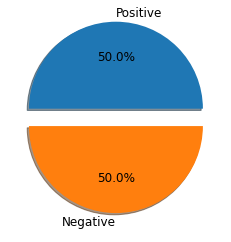

In [60]:
#Graph after the balancing the dataset
balanced=graph(pd.Series(bow_y_sm).value_counts(),['Positive','Negative'])
plt.show()

In [62]:
target_variable=pd.Series(bow_y_sm)

In [63]:
y_actual=target_variable.replace({'Negative':0,'Positive':1})

In [64]:
# Train Test Split
bow_x_train,bow_x_test, bow_y_train, bow_y_test = train_test_split(bow_x_sm, y_actual, test_size=0.3, random_state=42)

In [65]:
#Deleting the old data to save ram
del bow_df,bow_x_sm,bow_y_sm,target_variable,y_actual

#### MinMax Scaling 

In [66]:
# Funtion impliment scalling 
# scalling_fit will take scalling and data frame and return fit of dataset
def scalling_fit(sca,df):
    min_max=sca.fit(df)
    return min_max

# scalling_transform will take scalling and data frame and return transform dataset
def scalling_transform(scal,data):
  x_norm=scal.transform(data)
  return x_norm

In [67]:
scaler = MinMaxScaler()

In [68]:
# Implimenting scalling for bag of words
bow_scale=scalling_fit(scaler,bow_x_train)
bow_x_train_new=scalling_transform(bow_scale,bow_x_train)
bow_x_test_new=scalling_transform(bow_scale,bow_x_test)

In [69]:
# deleting old dataframe to save RAM 
del bow_x_train,bow_x_test

#### Model using Bag Of Words

In [70]:
# model will fit the data
def model(ml_model,x,y,x_test):
  ml_model.fit(x,y)
  y_pred=ml_model.predict(x_test)
  return ml_model,y_pred

In [71]:
#Model Evaluation
def model_evaluation(y_test,y_pred):
  confusion_mtx=confusion_matrix(y_test,y_pred)
  precission=precision_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)
  f1=f1_score(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_pred)
  class_report=classification_report(y_test,y_pred)
  return confusion_mtx, precission,recall,f1,accuracy,class_report

### Logestic regression Model

In [72]:
logestic_model = LogisticRegression(max_iter = 4000)

In [73]:
logesticModel,bow_y_pred_logestic=model(logestic_model,bow_x_train_new,bow_y_train,bow_x_test_new)

In [74]:
logesticModel

LogisticRegression(max_iter=4000)

In [75]:
bow_y_pred_logestic

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [76]:
# Function to print  model validation
def model_valid(confusion_mtx,precission,recall,f1,accuracy,class_report):
    print(f'Confusion matrix:\n {confusion_mtx}')
    print(f'Precision value : {precission}')
    print(f'recall value    : {recall}')
    print(f'f1 score value  : {f1}')
    print(f'accuracy value  : {accuracy}\n')
    print(f'Report: {class_report}')

In [77]:
# Calling evaluaction function for model performance evaluation
confusion_mtx,precission,recall,f1,accuracy,class_report=model_evaluation(bow_y_test,bow_y_pred_logestic)

In [78]:
#Printing logistic regression  model performance
model_valid(confusion_mtx,precission,recall,f1,accuracy,class_report)

Confusion matrix:
 [[7642  368]
 [ 656 7314]]
Precision value : 0.9520958083832335
recall value    : 0.9176913425345044
f1 score value  : 0.9345770508561205
accuracy value  : 0.9359198998748436

Report:               precision    recall  f1-score   support

           0       0.92      0.95      0.94      8010
           1       0.95      0.92      0.93      7970

    accuracy                           0.94     15980
   macro avg       0.94      0.94      0.94     15980
weighted avg       0.94      0.94      0.94     15980



#### We can see that accuracy is 93.5% using Logestic Regression

### Naive Bayes Model

In [79]:
naive_model = MultinomialNB()

In [80]:
# Calling naive-bayes model 
naiveModel,bow_y_pred_naive=model(naive_model,bow_x_train_new,bow_y_train,bow_x_test_new)

In [81]:
naiveModel

MultinomialNB()

In [82]:
# Predicted variables
bow_y_pred_naive

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [83]:
# Calling evaluaction function for model performance evaluation
confusion_mtx,precission,recall,f1,accuracy,class_report=model_evaluation(bow_y_test,bow_y_pred_naive)

In [84]:
#Printing naive bayse  model performance
model_valid(confusion_mtx,precission,recall,f1,accuracy,class_report)

Confusion matrix:
 [[5485 2525]
 [1575 6395]]
Precision value : 0.7169282511210763
recall value    : 0.8023839397741531
f1 score value  : 0.7572528123149794
accuracy value  : 0.7434292866082604

Report:               precision    recall  f1-score   support

           0       0.78      0.68      0.73      8010
           1       0.72      0.80      0.76      7970

    accuracy                           0.74     15980
   macro avg       0.75      0.74      0.74     15980
weighted avg       0.75      0.74      0.74     15980



#### We can see that accuracy is 74% with Naive Bayes model

### Random Forest

In [85]:
rf_model=RandomForestClassifier(n_estimators=100)

In [86]:
rfModel,bow_y_pred_rf=model(rf_model,bow_x_train_new,bow_y_train,bow_x_test_new)

In [87]:
rfModel

RandomForestClassifier()

In [88]:
bow_y_pred_rf

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [89]:
# Calling evaluaction function for model performance evaluation
confusion_mtx,precission,recall,f1,accuracy,class_report=model_evaluation(bow_y_test,bow_y_pred_rf)

In [90]:
#Printing Random forest  model performance
model_valid(confusion_mtx,precission,recall,f1,accuracy,class_report)

Confusion matrix:
 [[7662  348]
 [ 477 7493]]
Precision value : 0.9556179058793521
recall value    : 0.9401505646173149
f1 score value  : 0.9478211371829739
accuracy value  : 0.9483729662077597

Report:               precision    recall  f1-score   support

           0       0.94      0.96      0.95      8010
           1       0.96      0.94      0.95      7970

    accuracy                           0.95     15980
   macro avg       0.95      0.95      0.95     15980
weighted avg       0.95      0.95      0.95     15980



#### As we can see the accuracy is 94.8% with random forest model

### XG Boost

In [91]:
xgb_model = XGBClassifier(n_estimators=100)

In [92]:
xgbModel,bow_y_pred_xgb=model(xgb_model,bow_x_train_new,bow_y_train,bow_x_test_new)

In [93]:
xgbModel

XGBClassifier()

In [94]:
bow_y_pred_xgb

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

In [95]:
# Calling evaluaction function for model performance evaluation
confusion_mtx,precission,recall,f1,accuracy,class_report=model_evaluation(bow_y_test,bow_y_pred_xgb)

In [96]:
#Printing XG Boost  model performance
model_valid(confusion_mtx,precission,recall,f1,accuracy,class_report)

Confusion matrix:
 [[7516  494]
 [1316 6654]]
Precision value : 0.9308897593732512
recall value    : 0.8348808030112923
f1 score value  : 0.8802751686731048
accuracy value  : 0.8867334167709637

Report:               precision    recall  f1-score   support

           0       0.85      0.94      0.89      8010
           1       0.93      0.83      0.88      7970

    accuracy                           0.89     15980
   macro avg       0.89      0.89      0.89     15980
weighted avg       0.89      0.89      0.89     15980



#### As we can see the accuracy is 88% with XG Boost model

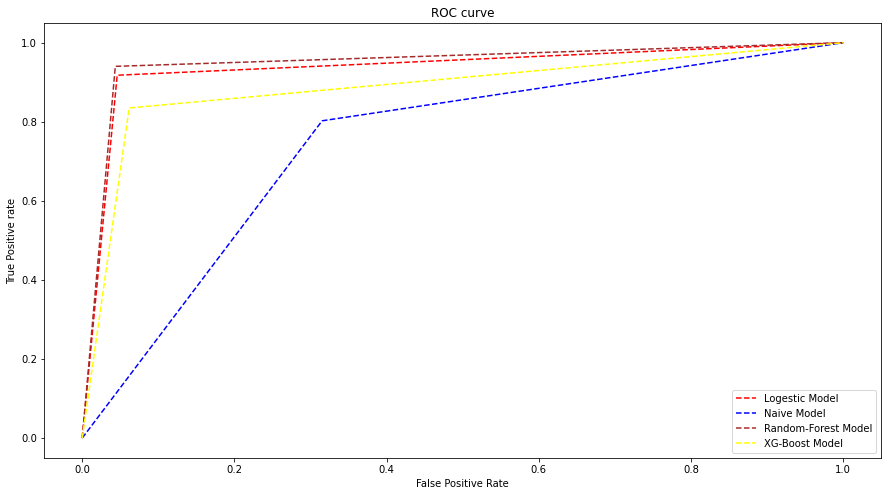

In [97]:
#Plotting roc curve for models
fpr1, tpr1, thresh1 = roc_curve(bow_y_test, bow_y_pred_logestic, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(bow_y_test, bow_y_pred_naive, pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(bow_y_test, bow_y_pred_rf, pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(bow_y_test, bow_y_pred_xgb, pos_label=1)

plt.figure(figsize=(15,8))
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='Logestic Model')
plt.plot(fpr2, tpr2, linestyle='--',color='blue', label='Naive Model')
plt.plot(fpr3, tpr3, linestyle='--',color='brown', label='Random-Forest Model')
plt.plot(fpr4, tpr4, linestyle='--',color='yellow', label='XG-Boost Model')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

#### Therefore the best model is Random Forest

In [98]:
#Deleting other models
del bow_scale,bow_x_test_new
del bow_y_pred_logestic,bow_y_pred_naive,bow_y_pred_rf,bow_y_pred_xgb,bow_y_test
del fpr1, tpr1, thresh1,fpr2, tpr2, thresh2,fpr3, tpr3, thresh3,fpr4, tpr4, thresh4

In [99]:
 del bow_x_train_new

In [250]:
# Saving randome forest model for prediction
pickle.dump(rfModel, open('Final_rf_Model.pickel', 'wb'))

## Recommendation System 

#### Data Cleaning

In [138]:
#Creating new dataframe with required columns
ratings_new=df[['name','reviews_rating','reviews_username']]

In [139]:
ratings_new.shape

(30000, 3)

In [140]:
ratings_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   reviews_username  29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [141]:
ratings_new.head()

,name,reviews_rating,reviews_username
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,K-Y Love Sensuality Pleasure Gel,1,walker557


In [142]:
#calculating the number of null value percentage in the dataframe
ratings_new.isnull().sum()*100/ratings_new.shape[0]

name                0.00
reviews_rating      0.00
reviews_username    0.21
dtype: float64

In [143]:
#Filling null values with 'undecided' word
ratings_new['reviews_username']=ratings_new['reviews_username'].fillna('undecided')

In [144]:
#Checking the percentage of null values again
ratings_new.isnull().sum()*100/ratings_new.shape[0]

name                0.0
reviews_rating      0.0
reviews_username    0.0
dtype: float64

#### We can see that now there are no null vaues in the dataframe¶

In [145]:
#Removing duplicate values 
ratings_new = ratings_new.drop_duplicates(subset=['name','reviews_username'] ,keep="first")

In [146]:
#Checking the shape of dataframe after duplicate entries removal
ratings_new.shape

(27605, 3)

In [147]:
#Checking the first few entries of dataframe
ratings_new.head()

,name,reviews_rating,reviews_username
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,K-Y Love Sensuality Pleasure Gel,1,walker557
5,K-Y Love Sensuality Pleasure Gel,1,samantha


In [148]:
#Converting the entries into lower case
ratings_new['name']=ratings_new['name'].apply(lambda x:x.lower())
ratings_new['reviews_username']=ratings_new['reviews_username'].apply(lambda x:x.lower())

In [149]:
#Displaying first few entries after the conversion in dataframe
ratings_new.head()

,name,reviews_rating,reviews_username
0,pink friday: roman reloaded re-up (w/dvd),5,joshua
1,lundberg organic cinnamon toast rice cakes,5,dorothy w
3,k-y love sensuality pleasure gel,1,rebecca
4,k-y love sensuality pleasure gel,1,walker557
5,k-y love sensuality pleasure gel,1,samantha


### Dividing the dataset into train and test

In [150]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings_new, test_size=0.30, random_state=31)

In [151]:
print(train.shape)
print(test.shape)

(19323, 3)
(8282, 3)


In [153]:
# Pivot the train ratings' dataset into matrix format.
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)
df_pivot.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
df_pivot.shape

(17883, 251)

### Creating dummy train & dummy test dataset
These dataset will be used for prediction

Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [155]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [156]:
dummy_train.head()

,name,reviews_rating,reviews_username
13289,clorox disinfecting wipes value pack scented 1...,5,jennifer5484
26613,aveeno baby continuous protection lotion sunsc...,5,ash
27819,planes: fire rescue (2 discs) (includes digita...,5,thekids
29745,l'or233al paris elvive extraordinary clay reba...,5,michelle2402
21920,"caress moisturizing body bar natural silk, 4.75oz",4,joem


In [157]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [158]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [159]:
dummy_train.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Cosine Similarity

Cosine Similarity is a measurement that quantifies the similarity between two vectors

<b>Adjusted Cosine</b>

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.

### User Similarity Matrix

### Using Cosine Similarity

In [160]:
df_pivot.index.nunique()

17883

In [163]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [164]:
user_correlation.shape

(17883, 17883)

### Using adjusted Cosine¶

Here, we are not removing the NaN values and calculating the mean only for the products rated by the user### 

In [165]:
# Create a user-movie matrix.
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [166]:
df_pivot.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Normalising the rating of the product for each user around 0 mean

In [168]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [169]:
df_subtracted.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity 

In [170]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation_adjusted_cosine = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation_adjusted_cosine[np.isnan(user_correlation_adjusted_cosine)] = 0
print(user_correlation_adjusted_cosine)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [171]:
user_correlation_adjusted_cosine.shape

(17883, 17883)

### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [172]:
user_correlation_adjusted_cosine[user_correlation_adjusted_cosine<0]=0
user_correlation_adjusted_cosine

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset).

In [174]:
user_predicted_ratings_cosine = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings_cosine

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 20.11479381,  0.        , ..., 13.77421445,
         1.87265836,  2.46182982],
       [ 0.        , 20.11479381,  0.        , ..., 13.77421445,
         1.87265836,  2.46182982],
       ...,
       [ 0.        ,  8.38033508,  0.        , ..., 10.62025659,
         4.11142408,  0.        ],
       [ 0.        ,  0.78279369,  0.        , ..., 11.63206456,
         4.7594097 ,  1.22474487],
       [ 0.        ,  8.38033508,  0.        , ..., 10.62025659,
         4.11142408,  0.        ]])

In [175]:
user_predicted_ratings_adjusted_cosine = np.dot(user_correlation_adjusted_cosine, df_pivot.fillna(0))
user_predicted_ratings_adjusted_cosine

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [176]:
print(user_predicted_ratings_cosine.shape)
print(user_predicted_ratings_adjusted_cosine.shape)

(17883, 251)
(17883, 251)


Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero.

In [178]:
user_final_rating_cosine = np.multiply(user_predicted_ratings_cosine,dummy_train)
user_final_rating_adjusted_cosine = np.multiply(user_predicted_ratings_adjusted_cosine,dummy_train)
user_final_rating_adjusted_cosine.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding the top 5 recommendation for the user¶

In [183]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user name02deuce
02deuce


In [184]:
adjusted_cosine = user_final_rating_adjusted_cosine.loc[user_input].sort_values(ascending=False)[0:5]
cosine = user_final_rating_cosine.loc[user_input].sort_values(ascending=False)[0:5]
print(cosine,adjusted_cosine)

name
mike dave need wedding dates (dvd + digital)                           99.526643
planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd)    90.147605
the resident evil collection 5 discs (blu-ray)                         88.778821
my big fat greek wedding 2 (blu-ray + dvd + digital)                   75.070176
red (special edition) (dvdvideo)                                       65.255852
Name: 02deuce, dtype: float64 name
yes to grapefruit rejuvenating body wash               0.0
equals (blu-ray)                                       0.0
heinz tomato ketchup, 38oz                             0.0
head & shoulders dandruff shampoo ocean lift 2 in 1    0.0
head & shoulders classic clean conditioner             0.0
Name: 02deuce, dtype: float64


In [185]:
with open('reccomendation_system_cosine_new.pickle', 'wb') as f:
    pickle.dump(user_final_rating_cosine, f)

### Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [186]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1107, 3)

In [187]:
common.head()

,name,reviews_rating,reviews_username
27491,planes: fire rescue (2 discs) (includes digita...,4,erin
20210,clorox disinfecting bathroom cleaner,5,rissia
6380,"hormel chili, no beans",5,lisa
22936,godzilla 3d includes digital copy ultraviolet ...,2,renee
11930,clorox disinfecting wipes value pack scented 1...,5,wheezie


In [188]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [189]:
common_user_based_matrix.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),africa's best no-lye dual conditioning relaxer system super,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",...,various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee",windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abismomy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ac94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [191]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17873,17874,17875,17876,17877,17878,17879,17880,17881,17882
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [192]:
df_subtracted.head(1)

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
user_correlation_df['reviews_username'] = df_subtracted.index

user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17873,17874,17875,17876,17877,17878,17879,17880,17881,17882
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
06stidriver,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [194]:
common.head(1)

,name,reviews_rating,reviews_username
27491,planes: fire rescue (2 discs) (includes digita...,4,erin


In [195]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [196]:
user_correlation_df_1.shape

(917, 17883)

In [197]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [198]:
user_correlation_df_3 = user_correlation_df_2.T

In [199]:
user_correlation_df_3.head()

,1234,abbi,abby,abismomy,ac94,acjuarez08,actionaction,adam,adelynsmom,adriana9999,...,wolverine,wonderwoman,wonster67,worm,wvshopaholic,xstr8edgex,yeyo,yummy,zippy,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.0,0.0,0.0,0.529813,0.529813,0.529813,0.0,0.529813,0.529813,...,0.0,0.0,0.0,0.0,0.0,0.662266,0.0,0.0,0.0,0.0
abbi,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
abby,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
abismomy,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0
ac94,0.529813,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [200]:
user_correlation_df_3.shape

(917, 917)

In [201]:
user_correlation_df_3[user_correlation_df_3<0]=0
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  5.96039561,  0.        , ..., 14.15935769,
         0.        ,  0.66845852],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  5.54148991,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  5.16235939,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [202]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [203]:
dummy_test.shape

(917, 124)

In [204]:
common_user_based_matrix.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),africa's best no-lye dual conditioning relaxer system super,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",...,various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee",windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abismomy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ac94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
dummy_test.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),africa's best no-lye dual conditioning relaxer system super,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",...,various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee",windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abismomy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ac94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [207]:
common_user_predicted_ratings.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),africa's best no-lye dual conditioning relaxer system super,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",...,various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee",windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abismomy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ac94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [208]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [209]:
print(type(y))

<class 'numpy.ndarray'>


In [210]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [211]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
print(total_non_nan)

1107


In [212]:
rmse = (((common_ - y)**2).sum()/total_non_nan).sum()**0.5
print(rmse)

2.1634671100715344


#### User-User rmse is 2.16

### Using Item similarity

## Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different name. In the user based similarity, we had taken mean for each user instead of each product.

In [213]:
df_pivot = train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

In [214]:
df_pivot.head()

reviews_username,00dog3,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zpalma,zsazsa,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:complete first season (blu-ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x ultra era with oxi booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 dual drop leaf table with 2 madrid chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the product rating for each movie for using the Adujsted Cosine

In [215]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [216]:
df_subtracted.head()

reviews_username,00dog3,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1085,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zpalma,zsazsa,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:complete first season (blu-ray),NaN,NaN,NaN,NaN,NaN,0.336842,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x ultra era with oxi booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 dual drop leaf table with 2 madrid chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [218]:
item_correlation.shape

(251, 251)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [219]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [220]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00737942, 0.00433576,
        0.00184633],
       [0.        , 0.        , 0.        , ..., 0.00590354, 0.00346861,
        0.00147706],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04929854, 0.        , ..., 0.        , 0.02237135,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [221]:
item_predicted_ratings.shape

(17883, 251)

In [222]:
dummy_train.shape

(17883, 251)

### Filtering the rating only for the product not rated by the user for recommendation

In [223]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz","42 dual drop leaf table with 2 madrid chairs""",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",...,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.006799,0.0,0.000000,0.0,0.0,0.007379,0.004336,0.001846
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.005439,0.0,0.000000,0.0,0.0,0.005904,0.003469,0.001477
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006255,...,0.0,0.0,0.000000,0.0,0.006255,0.0,0.0,0.000000,0.000000,0.000000
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006255,...,0.0,0.0,0.000000,0.0,0.006255,0.0,0.0,0.000000,0.000000,0.000000


#### Finding the top 5 recommendation for the user

In [226]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user name06stidriver
06stidriver


In [227]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
clorox disinfecting bathroom cleaner                        0.624393
scooby doo and the loch ness monster (blu-ray)              0.092912
toy story kids' woody accessory kit                         0.052892
clambake (dvd)                                              0.020485
nature's path chunky chocolate peanut chewy granola bars    0.019779
Name: 06stidriver, dtype: float64

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, we will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [228]:
test.columns

Index(['name', 'reviews_rating', 'reviews_username'], dtype='object')

In [229]:
common =  test[test.name.isin(train.name)]
common.shape

(8260, 3)

In [230]:
common.head()

,name,reviews_rating,reviews_username
13119,clorox disinfecting wipes value pack scented 1...,5,cloroxlover4evarrr
3670,arrid extra dry anti-perspirant deodorant spra...,4,kays
6443,"hormel chili, no beans",5,katcookie
22243,alex cross (dvdvideo),4,par2golf
4946,the resident evil collection 5 discs (blu-ray),5,sxiong8


In [231]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [232]:
common_item_based_matrix.shape

(196, 7928)

In [233]:
item_correlation_df = pd.DataFrame(item_correlation)

In [234]:
item_correlation_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [235]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
name,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:complete first season (blu-ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x ultra era with oxi booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 dual drop leaf table with 2 madrid chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [236]:
list_name = common.name.tolist()

In [237]:
len(list_name)

8260

In [238]:
df_subtracted.shape

(251, 17883)

In [239]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [240]:
item_correlation_df.shape

(251, 251)

In [241]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [242]:
item_correlation_df_3.head()

,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,...,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:complete first season (blu-ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x ultra era with oxi booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4c grated parmesan cheese 100% natural 8oz shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [243]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0397039 , 0.        , 0.        , ..., 0.        , 0.02306966,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00442765, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01342281, 0.00260145, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0011078 , 0.        , ..., 0.        , 0.01385098,
        0.        ]])

In [244]:
common_item_predicted_ratings.shape

(196, 7928)

 Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [245]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

In [246]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [247]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [248]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [249]:
rmse = (((common_ - y)**2).sum()/total_non_nan).sum()**0.5
print(rmse)

3.57516624028012


### Summary - Recommendation Engine

#### RMSE for item-item is 3.5
#### RMSE for user-user is 2.1

##### Hence, we can conclude that user-user is the better one recommendation Engine